# LSTM 302
Start with LSTM 201 and modify it to use our updated code infrastructure.

In [1]:
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'
MODEL_FILE='LSTM302'   # load not save!
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
NC_FILENAME = DATAPATH+NC_FILENAME
PC_FILENAME = DATAPATH+PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=100
SPLITS=1
K=3
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
NEURONS=16
DROP=0.25
ACT="tanh"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# Load our own tools
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
#from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [9]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=10000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    embed_layer  = keras.layers.Embedding(
        #VOCABULARY_SIZE, EMBED_DIMEN, input_length=1000, input_length=1000, mask_zero=True)
        #input_dim=[None,VOCABULARY_SIZE], output_dim=EMBED_DIMEN, mask_zero=True)
        input_dim=VOCABULARY_SIZE, output_dim=EMBED_DIMEN, mask_zero=True)
    rnn1_layer = keras.layers.Bidirectional(
      keras.layers.LSTM(NEURONS, return_sequences=True, 
          input_shape=[1000,EMBED_DIMEN], activation=ACT, dropout=DROP) )#bi
    rnn2_layer = keras.layers.Bidirectional(
      keras.layers.LSTM(NEURONS, return_sequences=False, 
        activation=ACT, dropout=DROP) )#bi
    dense1_layer = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    drop1_layer = keras.layers.Dropout(DROP)
    dense2_layer = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    drop2_layer = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)
    mlp = keras.models.Sequential()
    mlp.add(embed_layer)
    mlp.add(rnn1_layer)
    mlp.add(rnn2_layer)
    mlp.add(dense1_layer)
    mlp.add(drop1_layer)
    mlp.add(dense2_layer)
    mlp.add(drop2_layer)
    mlp.add(output_layer)
    mlpc = compile_model(mlp)
    return mlpc

Partition sequences

In [5]:
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

Cross validation

In [6]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [7]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=tools.load_fasta(NC_FILENAME,0)
pc_seq=tools.load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("Data reshape")
(X_train,y_train)=tools.make_kmers(K,MAXLEN,subset)
#print ("Data prep")
#X_train=tools.make_frequencies(K,X_train)

Load data from files.
Ready: train_set
Data reshape


In [10]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          1040      
_________________________________________________________________
bidirectional (Bidirectional (None, None, 32)          4224      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_____________________________________________________________

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.model/assets


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/100
453/453 [==============================] - 72s 131ms/step - loss: 0.6133 - accuracy: 0.6797 - val_loss: 0.6158 - val_accuracy: 0.6766


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 2/100
453/453 [==============================] - 56s 124ms/step - loss: 0.5750 - accuracy: 0.7180 - val_loss: 0.5190 - val_accuracy: 0.7449


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 3/100
453/453 [==============================] - 56s 123ms/step - loss: 0.5395 - accuracy: 0.7409 - val_loss: 0.5244 - val_accuracy: 0.7573


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 4/100
453/453 [==============================] - 56s 124ms/step - loss: 0.5671 - accuracy: 0.7155 - val_loss: 0.5324 - val_accuracy: 0.7511
Epoch 5/100
453/453 [==============================] - 56s 124ms/step - loss: 0.5528 - accuracy: 0.7361 - val_loss: 0.5352 - val_accuracy: 0.7393
Epoch 6/100
453/453 [==============================] - 56s 124ms/step - loss: 0.5574 - accuracy: 0.7295 - val_loss: 0.5617 - val_accuracy: 0.7176
Epoch 7/100
453/453 [==============================] - 56s 124ms/step - loss: 0.5655 - accuracy: 0.7181 - val_loss: 0.5200 - val_accuracy: 0.7492
Epoch 8/100
453/453 [==============================] - 56s 124ms/step - loss: 0.5453 - accuracy: 0.7350 - val_loss: 0.5365 - val_accuracy: 0.7387
Epoch 9/100
453/453 [==============================] - 56s 124ms/step - loss: 0.5492 - accuracy: 0.7334 - val_loss: 0.5015 - val_accuracy: 0.7716


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 10/100
453/453 [==============================] - 56s 124ms/step - loss: 0.5531 - accuracy: 0.7312 - val_loss: 0.5372 - val_accuracy: 0.7281
Epoch 11/100
453/453 [==============================] - 57s 125ms/step - loss: 0.5491 - accuracy: 0.7248 - val_loss: 0.5252 - val_accuracy: 0.7517
Epoch 12/100
453/453 [==============================] - 56s 124ms/step - loss: 0.5439 - accuracy: 0.7375 - val_loss: 0.5884 - val_accuracy: 0.7039
Epoch 13/100
453/453 [==============================] - 56s 125ms/step - loss: 0.5827 - accuracy: 0.7003 - val_loss: 0.5477 - val_accuracy: 0.7219
Epoch 14/100
453/453 [==============================] - 56s 124ms/step - loss: 0.5687 - accuracy: 0.7053 - val_loss: 0.5555 - val_accuracy: 0.7381
Epoch 15/100
453/453 [==============================] - 56s 124ms/step - loss: 0.5689 - accuracy: 0.7164 - val_loss: 0.5191 - val_accuracy: 0.7455
Epoch 16/100
453/453 [==============================] - 56s 124ms/step - loss: 0.5432 - accuracy: 0.7356 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 28/100
453/453 [==============================] - 56s 125ms/step - loss: 0.4777 - accuracy: 0.7819 - val_loss: 0.4595 - val_accuracy: 0.7983


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 29/100
453/453 [==============================] - 56s 124ms/step - loss: 0.5243 - accuracy: 0.7435 - val_loss: 0.5087 - val_accuracy: 0.7498
Epoch 30/100
453/453 [==============================] - 56s 124ms/step - loss: 0.5583 - accuracy: 0.7088 - val_loss: 0.5732 - val_accuracy: 0.7337
Epoch 31/100
453/453 [==============================] - 56s 124ms/step - loss: 0.5610 - accuracy: 0.7260 - val_loss: 0.5248 - val_accuracy: 0.7542
Epoch 32/100
453/453 [==============================] - 56s 124ms/step - loss: 0.5206 - accuracy: 0.7445 - val_loss: 0.4694 - val_accuracy: 0.7877
Epoch 33/100
453/453 [==============================] - 56s 124ms/step - loss: 0.4757 - accuracy: 0.7882 - val_loss: 0.4563 - val_accuracy: 0.8007


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 34/100
453/453 [==============================] - 56s 124ms/step - loss: 0.4409 - accuracy: 0.8040 - val_loss: 0.3943 - val_accuracy: 0.8187


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 35/100
453/453 [==============================] - 56s 125ms/step - loss: 0.4287 - accuracy: 0.8098 - val_loss: 0.4198 - val_accuracy: 0.8206


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 36/100
453/453 [==============================] - 56s 125ms/step - loss: 0.4357 - accuracy: 0.8065 - val_loss: 0.3846 - val_accuracy: 0.8318


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 37/100
453/453 [==============================] - 56s 125ms/step - loss: 0.4159 - accuracy: 0.8179 - val_loss: 0.4378 - val_accuracy: 0.8020
Epoch 38/100
453/453 [==============================] - 56s 124ms/step - loss: 0.4086 - accuracy: 0.8237 - val_loss: 0.3714 - val_accuracy: 0.8305
Epoch 39/100
453/453 [==============================] - 57s 125ms/step - loss: 0.4105 - accuracy: 0.8198 - val_loss: 0.3704 - val_accuracy: 0.8423


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 40/100
453/453 [==============================] - 56s 124ms/step - loss: 0.4087 - accuracy: 0.8227 - val_loss: 0.3823 - val_accuracy: 0.8324
Epoch 41/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3894 - accuracy: 0.8288 - val_loss: 0.3700 - val_accuracy: 0.8367
Epoch 42/100
453/453 [==============================] - 56s 124ms/step - loss: 0.4104 - accuracy: 0.8192 - val_loss: 0.3664 - val_accuracy: 0.8355
Epoch 43/100
453/453 [==============================] - 56s 124ms/step - loss: 0.4033 - accuracy: 0.8236 - val_loss: 0.3673 - val_accuracy: 0.8343
Epoch 44/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3994 - accuracy: 0.8239 - val_loss: 0.3743 - val_accuracy: 0.8343
Epoch 45/100
453/453 [==============================] - 56s 124ms/step - loss: 0.4001 - accuracy: 0.8296 - val_loss: 0.4165 - val_accuracy: 0.8163
Epoch 46/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3955 - accuracy: 0.8325 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 48/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3942 - accuracy: 0.8300 - val_loss: 0.3735 - val_accuracy: 0.8374
Epoch 49/100
453/453 [==============================] - 56s 125ms/step - loss: 0.3862 - accuracy: 0.8344 - val_loss: 0.3618 - val_accuracy: 0.8380
Epoch 50/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3909 - accuracy: 0.8274 - val_loss: 0.3581 - val_accuracy: 0.8454
Epoch 51/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3834 - accuracy: 0.8367 - val_loss: 0.3667 - val_accuracy: 0.8374
Epoch 52/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3792 - accuracy: 0.8353 - val_loss: 0.3516 - val_accuracy: 0.8454
Epoch 53/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3877 - accuracy: 0.8350 - val_loss: 0.3617 - val_accuracy: 0.8436
Epoch 54/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3915 - accuracy: 0.8300 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 58/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3677 - accuracy: 0.8425 - val_loss: 0.3458 - val_accuracy: 0.8461
Epoch 59/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3790 - accuracy: 0.8334 - val_loss: 0.4283 - val_accuracy: 0.8026
Epoch 60/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3799 - accuracy: 0.8352 - val_loss: 0.3471 - val_accuracy: 0.8417
Epoch 61/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3698 - accuracy: 0.8451 - val_loss: 0.3490 - val_accuracy: 0.8498


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 62/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3657 - accuracy: 0.8450 - val_loss: 0.3740 - val_accuracy: 0.8361
Epoch 63/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3638 - accuracy: 0.8414 - val_loss: 0.3927 - val_accuracy: 0.8231
Epoch 64/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3669 - accuracy: 0.8442 - val_loss: 0.3599 - val_accuracy: 0.8417
Epoch 65/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3648 - accuracy: 0.8431 - val_loss: 0.3452 - val_accuracy: 0.8479
Epoch 66/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3592 - accuracy: 0.8471 - val_loss: 0.3407 - val_accuracy: 0.8454
Epoch 67/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3668 - accuracy: 0.8415 - val_loss: 0.3391 - val_accuracy: 0.8529


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 68/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3689 - accuracy: 0.8391 - val_loss: 0.3409 - val_accuracy: 0.8498
Epoch 69/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3725 - accuracy: 0.8435 - val_loss: 0.3451 - val_accuracy: 0.8442
Epoch 70/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3782 - accuracy: 0.8382 - val_loss: 0.3447 - val_accuracy: 0.8492
Epoch 71/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3579 - accuracy: 0.8503 - val_loss: 0.3421 - val_accuracy: 0.8461
Epoch 72/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3507 - accuracy: 0.8527 - val_loss: 0.3429 - val_accuracy: 0.8399
Epoch 73/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3595 - accuracy: 0.8471 - val_loss: 0.3380 - val_accuracy: 0.8461
Epoch 74/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3506 - accuracy: 0.8481 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 81/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3504 - accuracy: 0.8493 - val_loss: 0.3408 - val_accuracy: 0.8473
Epoch 82/100
453/453 [==============================] - 56s 123ms/step - loss: 0.3533 - accuracy: 0.8502 - val_loss: 0.3431 - val_accuracy: 0.8479
Epoch 83/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3660 - accuracy: 0.8508 - val_loss: 0.3802 - val_accuracy: 0.8367
Epoch 84/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3459 - accuracy: 0.8548 - val_loss: 0.3567 - val_accuracy: 0.8436
Epoch 85/100
453/453 [==============================] - 56s 125ms/step - loss: 0.3524 - accuracy: 0.8533 - val_loss: 0.3380 - val_accuracy: 0.8523
Epoch 86/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3475 - accuracy: 0.8515 - val_loss: 0.3459 - val_accuracy: 0.8380
Epoch 87/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3365 - accuracy: 0.8604 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 90/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3342 - accuracy: 0.8626 - val_loss: 0.3365 - val_accuracy: 0.8523
Epoch 91/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3351 - accuracy: 0.8594 - val_loss: 0.3339 - val_accuracy: 0.8523
Epoch 92/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3269 - accuracy: 0.8611 - val_loss: 0.3333 - val_accuracy: 0.8523
Epoch 93/100
453/453 [==============================] - 56s 125ms/step - loss: 0.3222 - accuracy: 0.8675 - val_loss: 0.3277 - val_accuracy: 0.8529
Epoch 94/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3296 - accuracy: 0.8621 - val_loss: 0.3635 - val_accuracy: 0.8324
Epoch 95/100
453/453 [==============================] - 56s 125ms/step - loss: 0.3210 - accuracy: 0.8614 - val_loss: 0.3326 - val_accuracy: 0.8579


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 96/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3237 - accuracy: 0.8644 - val_loss: 0.3393 - val_accuracy: 0.8541
Epoch 97/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3181 - accuracy: 0.8695 - val_loss: 0.3352 - val_accuracy: 0.8566
Epoch 98/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3230 - accuracy: 0.8654 - val_loss: 0.3250 - val_accuracy: 0.8616


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/LSTM302.cv.1.best/assets


Epoch 99/100
453/453 [==============================] - 56s 125ms/step - loss: 0.3366 - accuracy: 0.8584 - val_loss: 0.3348 - val_accuracy: 0.8554
Epoch 100/100
453/453 [==============================] - 56s 124ms/step - loss: 0.3237 - accuracy: 0.8634 - val_loss: 0.3693 - val_accuracy: 0.8442
Fold 1, 100 epochs, 6363 sec


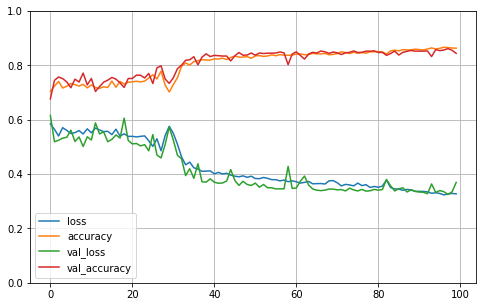

accuracy: 86.16%

1-way Cross Validation mean 86.16% (+/- 0.00%)
Done


In [11]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")